# 量子機械学習によるデフォルト予測

## セットアップ

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import pandas as pd
import category_encoders as ce

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

#その他の設定


## 1. データの読み込み

In [186]:
main_path="C:/Users/finst/OneDrive/デスクトップ/wataru/13_仕事/量子機械学習/home-credit-default-risk"
path_all_data=main_path+"/application.csv" #特徴量データのパス
path_testID=main_path+"/test_key.csv" #テストデータのID
path_trainID=main_path+"/train_key.csv" #訓練データのID

### 1.1 生データを読み込む

全てのデータを読み込む

In [187]:
all_data = pd.read_csv(path_all_data)
testID = pd.read_csv(path_testID)
trainID = pd.read_csv(path_trainID)
#データサイズを確認
all_data.shape

(356255, 121)

### 1.2 データの前処理

#### 【欠損の確認】

<AxesSubplot:>

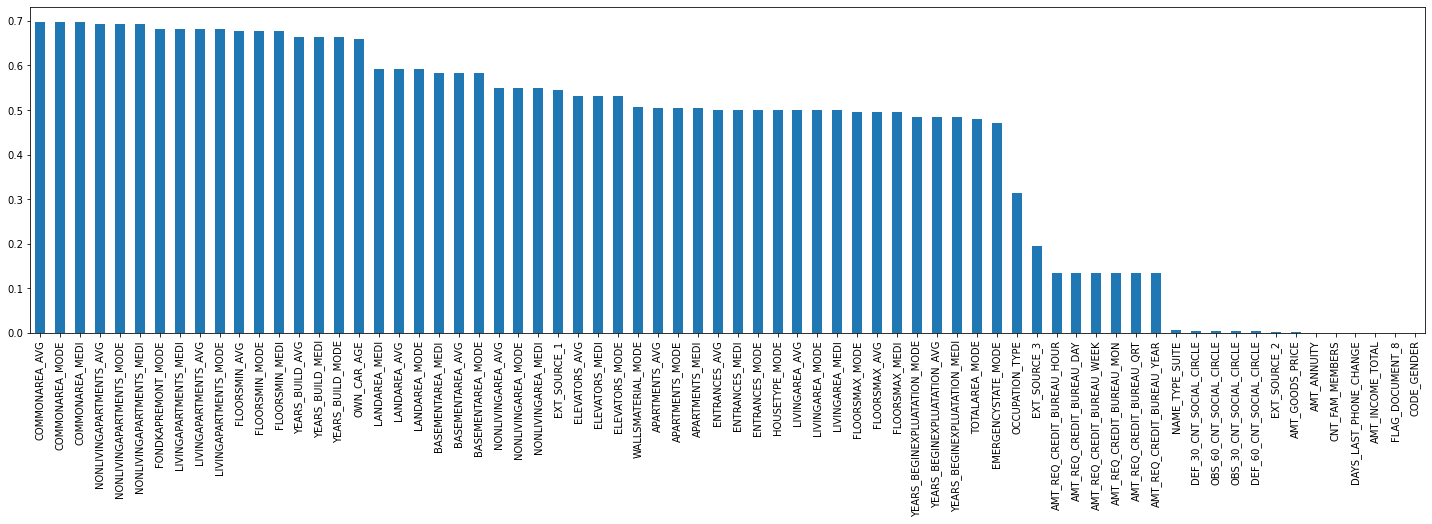

In [188]:
extract_num =70
na_ratio=(all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False)[:extract_num]
plt.figure(figsize=(25,6))
na_ratio.plot.bar()

#### 【4割以上欠損している列を削除】

In [189]:
#半分以上欠損している列の名前をリストアップ
missing_col=[]
for i in range(len(na_ratio)):
    if na_ratio[i]>0.4:
        missing_col.append(na_ratio.index[i])

#列から削除
all_data = all_data.drop(missing_col,axis=1)

#### 【量的変数は欠損を平均値で埋め，標準化】

In [172]:
all_data.to_csv("C:/Users/finst/OneDrive/デスクトップ/wataru/13_仕事/量子機械学習/all_data.csv")

In [190]:
# onehotにする列を指定
list_onehot = ["NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_HOUSING_TYPE","NAME_EDUCATION_TYPE",
               "NAME_FAMILY_STATUS","OCCUPATION_TYPE",
               "WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE"]
#01に置き換える列を指定
list_01 = ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY"]

#量的変数
merge =list_onehot+list_01
list_quantity = list(set(all_data.columns)-set(merge))


In [191]:
# 量的変数は平均値で埋める
for col in all_data.columns[1:]:
    if col not in merge:
        all_data[col]=all_data[col].fillna(all_data[col].mean())
        all_data[col]=(all_data[col]-all_data[col].mean())/all_data[col].std()
        
#01に置き換える
for col in list_01:
    if col == "NAME_CONTRACT_TYPE":
        all_data[col].replace(["Cash loans","Revolving loans"],[0,1],inplace=True)
    elif col=="CODE_GENDER":
        all_data[col].replace(["F","M"],[0,1],inplace=True)
    elif col=="FLAG_OWN_CAR":
        all_data[col].replace(["N","Y"],[0,1],inplace=True) 
    elif col=="FLAG_OWN_REALTY":
        all_data[col].replace(["N","Y"],[0,1],inplace=True) 

all_data=all_data[all_data.CODE_GENDER!="XNA"]
#onehotにする
ce_ohe = ce.OneHotEncoder(cols=list_onehot,handle_unknown='impute')
all_data = ce_ohe.fit_transform(all_data)

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#### 【01データへの変換】

In [200]:
#01のデータへ変換
threshold=0

def trans01(x):
    if x>threshold:
        return 1
    else:
        return 0

#訓練データとテストデータへ分割
all_data_train = all_data[all_data.SK_ID_CURR.isin(trainID.SK_ID_CURR.tolist())]
all_data_test = all_data[all_data.SK_ID_CURR.isin(testID.SK_ID_CURR.tolist())]


for col in list_quantity:
    all_data_train[col]=all_data_train[col].apply(trans01)
    all_data_test[col]=all_data_test[col].apply(trans01)

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [201]:
all_data_train

In [184]:
def convert_to_circuit(credit_info):
    qubits = cirq.GridQubit.rect(len(credit_info), 1)
    circuit = cirq.Circuit()
    for i, value in enumerate(credit_info):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

all_data = all_data.values.tolist()



In [185]:
x_train_circ = [convert_to_circuit(x) for x in all_data]
x_test_circ = [convert_to_circuit(x) for x in all_data]

KeyboardInterrupt: 

これは最初のサンプルに作成された回路です（回路図には、ゼロゲートのキュービットは表示されていません）。

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


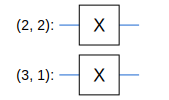

In [16]:
SVGCircuit(x_train_circ[0])

この回路を、画像の値がしきい値を超えるインデックスを比較します。

In [17]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

これらの `Cirq` 回路を `tfq` のテンソルに変換します。

In [18]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. 量子ニューラルネットワーク

画像を分類する量子回路構造に関するガイダンスはほとんどありません。分類は読み出されるキュービットの期待に基づいて行われるため、<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、2 つのキュービットゲートを使用して、読み出しキュービットが必ず作用されるようにすることを提案しています。これはある意味、ピクセル全体に小さな<a href="https://arxiv.org/abs/1511.06464" class="external">ユニタリ RNN</a>を実行することに似ています。

### 2.1 モデル回路を構築する

次の例では、このレイヤー化アプローチを説明しています。各レイヤーは同一ゲートの *n* 個のインスタンスを使用しており、各データキュービットは読み出しキュービットに影響を与えています。

ゲートのレイヤーを回路に追加する簡単なクラスから始めましょう。

In [19]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

サンプル回路レイヤーを構築して、どのようになるかを確認します。

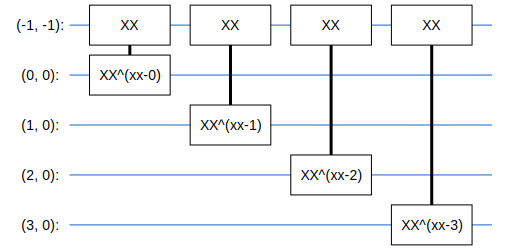

In [20]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

では、2 レイヤーモデルを構築しましょう。 データ回路サイズに一致するようにし、準備と読み出し演算を含めます。

In [21]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [22]:
model_circuit, model_readout = create_quantum_model()

### 2.2 tfq-keras モデルでモデル回路をラップする

量子コンポーネントで Keras モデルを構築します。このモデルには、古典的なデータをエンコードする「量子データ」が `x_train_circ` からフィードされます。*パラメータ化された量子回路*レイヤーの `tfq.layers.PQC` を使用して、量子データでモデル回路をトレーニングするモデルです。

<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、画像を分類するには、パラメータ化された回路で読み出しキュービットの期待値を使用することを提案しています。期待値は、1 から -1 の値です。

In [23]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

次に、`compile` メソッドを使用して、モデルにトレーニング手順を指定します。

期待される読み出しは `[-1,1]` の範囲であるため、ヒンジ損失を最適化すると、ある程度自然な適合となります。

注意: もう 1 つの有効なアプローチとして、出力範囲を `[0,1]` にシフトし、モデルがクラス `3` に割りてる確率として扱う方法があります。これは、標準的な`tf.losses.BinaryCrossentropy` 損失で使用することができます。

ここでヒンジ損失を使用するには、小さな調整を 2 つ行う必要があります。まず、ラベル `y_train_nocon` をブール型からヒンジ損失が期待する `[-1,1]` に変換することです。

In [24]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

次に、`[-1, 1]` を `y_true` ラベル引数として正しく処理するカスタムの `hinge_accuracy` メトリックを使用します。`tf.losses.BinaryAccuracy(threshold=0.0)` は `y_true` がブール型であることを期待するため、ヒンジ損失とは使用できません。

In [25]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [26]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### 量子モデルをトレーニングする

では、モデルをトレーニングしましょう。これには約 45 分かかりますが、その時間を待てない方は、小規模なデータのサブセット（以下の`NUM_EXAMPLES=500` セット）を使用するとよいでしょう。トレーニング時のモデルの進捗にあまり影響はありません（パラメータは 32 しかなく、これらを制約する上であまりデータは必要ありません）。サンプル数を減らすことでトレーニングを早めに（5 分程度）終わらせることができますが、検証ログに進捗状況を示すには十分な長さです。

In [28]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [29]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

このモデルを収束までトレーニングすると、テストセットにおいて 85% を超える精度が達成されます。

In [30]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
360/360 [==============================] - 157s 437ms/step - loss: 0.6086 - hinge_accuracy: 0.8227 - val_loss: 0.3569 - val_hinge_accuracy: 0.8992
Epoch 2/3
360/360 [==============================] - 154s 427ms/step - loss: 0.3384 - hinge_accuracy: 0.8885 - val_loss: 0.3415 - val_hinge_accuracy: 0.8634
Epoch 3/3
62/62 [==============================] - 4s 71ms/step - loss: 0.3409 - hinge_accuracy: 0.8649


注意: トレーニング精度はエポックの平均値を示します。検証精度はエポックの終了ごとに評価されます。

## 3. 従来のニューラルネットワーク

量子ニューラルネットワークは、この単純化された MNIST 問題で機能するものの、このタスクでは、従来のニューラルネットワークの性能が QNN をはるかに上回ります。1 つのエポックが終了した時点で、従来のニューラルネットワークは縮小したセットで 98% を超える精度を達成することができます。

次の例では、画像をサブサンプリングする代わりに 28x28 の画像を使用した 3 と 6 の分類問題に従来のニューラルネットワークを使用しています。これはほぼ 100% 精度のテストセットに難なく収束します。

In [31]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [32]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 0s 6ms/step - loss: 0.0072 - accuracy: 0.9990


上記のモデルには約 120 万個のパラメータがあります。より公正な比較を行うために、サブサンプリングした画像で 37 個のパラメータモデルを使用してみましょう。

In [33]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
90/90 - 0s - loss: 0.6959 - accuracy: 0.5040 - val_loss: 0.6573 - val_accuracy: 0.4888
Epoch 2/20
90/90 - 0s - loss: 0.6481 - accuracy: 0.5052 - val_loss: 0.6149 - val_accuracy: 0.4893
Epoch 3/20
90/90 - 0s - loss: 0.6044 - accuracy: 0.5059 - val_loss: 0.5689 - val_accuracy: 0.4903
Epoch 4/20
90/90 - 0s - loss: 0.5531 - accuracy: 0.5226 - val_loss: 0.4852 - val_accuracy: 0.6900
Epoch 5/20
90/90 - 0s - loss: 0.4309 - accuracy: 0.8578 - val_loss: 0.3653 - val_accuracy: 0.8806
Epoch 6/20
90/90 - 0s - loss: 0.3411 - accuracy: 0.8896 - val_loss: 0.3065 - val_accuracy: 0.8918
Epoch 7/20
90/90 - 0s - loss: 0.2935 - accuracy: 0.8959 - val_loss: 0.2751 - val_accuracy: 0.8943
Epoch 8/20
90/90 - 0s - loss: 0.2657 - accuracy: 0.9012 - val_loss: 0.2563 - val_accuracy: 0.9121
Epoch 9/20
90/90 - 0s - loss: 0.2482 - accuracy: 0.9081 - val_loss: 0.2440 - val_accuracy: 0.9121
Epoch 10/20
90/90 - 0s - loss: 0.2365 - accuracy: 0.9088 - val_loss: 0.2355 - val_accuracy: 0.9136
Epoch 11/20
90/90 -

## 4. 比較

解像度の高い入力とより強力なモデルの場合、CNN はこの問題を簡単に解決できますが、似たようなパワー（最大 32 個のパラメータ）を持つ古典的モデルはわずかな時間で似たような精度までトレーニングすることができます。いずれにせよ、従来のニューラルネットワークは量子ニューラルネットワークの性能を簡単に上回ります。古典的なデータでは、従来のニューラルネットワークを上回るのは困難といえます。

/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

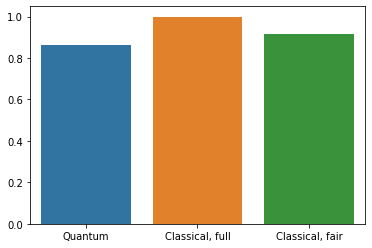

In [35]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])